# 方法介绍
- 样本选择：bubbly stratified veined 三类纹理每类 120 个，共 360 个样本

- 训练数据：随机 300 个样本

- 测试数据：随机 60 个样本

- 特征选取：hog 8100 维特征

- 分类器：
    1.k_nn（自己写的）选取 `[1, 5, 7, 9, 11, 13, 15]` 共 8 个不同的 k 值进行测试
    
    2.svm（调用sklearn） 选取 `['linear', 'sigmoid', 'poly', 'rbf']`
    
    共 4 个不同的核函数作为可调节超参
        
- 评估指标：精确率(Accuracy)，准确率(precision)，召回率(recall)，混淆矩阵

# 函数(或类)介绍

- `my_knn()`:有 `train_data` `labels` `result` 三个属性, 

    `fit(self, train_data, train_labels)` `predict(self, test_data, k)` 
    
    `score(self, labels)` 三个方法。
- `confusion_and_probability_matrix(scores, predict_result, tru_labels)`:

    生成混淆矩阵和准确率以及召回率。
- `train_svm(X_train, y_train,kenrel)`:训练svm分类器，返回svm分类器实例。

- `score_svm(svm, X, y)`:返回精确率。

In [1]:
# 导入各种必须的包
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [2]:
bubbly_img = []
stratified_img = []
veined_img = []
texture_bubbly_dir = 'texture\\bubbly'
texture_stratified_dir = 'texture\\stratified'
texture_veined_dir = 'texture\\veined'

In [3]:
for i in range(200):
    img = cv2.imread(texture_bubbly_dir+'\\bubbly_%04d.jpg'%(i),0)
    if not str(type(img)) == "<class 'NoneType'>":
        bubbly_img.append(img)
len(bubbly_img)# 导入120张 bubbly

120

In [4]:
for i in range(200):
    img = cv2.imread(texture_stratified_dir+'\\stratified_%04d.jpg'%(i),0)
    if not str(type(img)) == "<class 'NoneType'>":
        stratified_img.append(img)
len(stratified_img)# 导入120张 stratified

120

In [5]:
for i in range(200):
    img = cv2.imread(texture_veined_dir+'\\veined_%04d.jpg'%(i),0)
    if not str(type(img)) == "<class 'NoneType'>":
        veined_img.append(img)
len(veined_img)# 导入120张 veined

120

In [6]:
# my_knn类定义
class my_knn():
    def __init__(self): # 无形参初始化
        self.train_data = np.zeros(0)
        self.labels = np.zeros(0)
        self.result = np.zeros(0)
    def fit(self, train_data, train_labels): 
        # 导入训练数据，其中 train_data.shape 格式为(样本数, 特征数)，
        # train_label.shape 格式为(样本数)
        self.train_data = train_data
        self.labels = train_labels
    def predict(self, test_data, k): # 预测方法，返回预测标签
        predict_labels = np.zeros((test_data.shape[0])) 
        for i in range(test_data.shape[0]):
            distance = np.sum(np.square(test_data[i]-self.train_data),axis=1) 
            # 计算每个测试数据点与所有训练点的欧式距离
            indices = np.argsort(distance) # 对计算出的所有距离排序
            result = self.labels[indices][:k] # 提取排序后前 k 个训练点的标签
            predict_labels[i] = np.argmax(np.bincount(result)) 
            # 选择标签类最多的作为预测标签
        self.result = predict_labels
        return predict_labels
    def score(self, labels):
        return np.sum(self.result == labels)/labels.shape[0] # 精确率评分函数

In [7]:
# 定义 hog 特征，计算得有 8100 维的特征
win_size = (256, 256)
block_size = (32, 32)
block_stride = (16, 16)
cell_size = (16, 16)
num_bins = 9
hog = cv2.HOGDescriptor(win_size, block_size, block_stride,
                        cell_size, num_bins)

In [8]:
# 此部分为转换图片的 shape 并生成 hog 特征，以及打乱排列顺序
bubbly_img_shaped = np.array([cv2.resize(i,(256,256)) for i in bubbly_img])
stratified_img_shaped = np.array([cv2.resize(i,(256,256)) for i in stratified_img])
veined_img_shaped = np.array([cv2.resize(i,(256,256)) for i in veined_img])
all_img_data = np.concatenate((bubbly_img_shaped, stratified_img_shaped, 
                               veined_img_shaped))
all_img_labels = np.concatenate((np.ones((bubbly_img_shaped.shape[0]),
                        dtype=np.int32)*0,np.ones((stratified_img_shaped.shape[0]),
                        dtype=np.int32)*1,np.ones((veined_img_shaped.shape[0]),
                        dtype=np.int32)*2))
all_img_hog = \
np.array([hog.compute(i) for i in all_img_data]).reshape(all_img_data.shape[0],-1)
rate = 100
all_img_hog_mixed = np.array([np.mean(i[j*rate:j*rate+rate]) 
                              for i in all_img_hog 
                              for j in range(i.shape[0]//rate)]).reshape(360,-1)
indices = np.arange(all_img_data.shape[0])
np.random.seed(8888)
np.random.shuffle(indices)
all_img_data = all_img_data[indices]
all_img_hog = all_img_hog[indices]
all_img_hog_mixed = all_img_hog_mixed[indices]
all_img_labels = all_img_labels[indices]
all_img_data.shape, all_img_hog.shape, all_img_hog_mixed.shape, all_img_labels.shape

((360, 256, 256), (360, 8100), (360, 81), (360,))

In [9]:
# 这部分用于验证 my_knn 的正确性，将 k 设置为 1，用所有数据训练和测试，
# 得到 1.0 的精确率，即每个点都离自身最近，验证得算法正确
classify_model = my_knn()
classify_model.fit(all_img_hog, all_img_labels)
a = classify_model.predict(all_img_hog, 1)
classify_model.score(all_img_labels)

1.0

array([0.7       , 0.68333333, 0.73333333, 0.76666667, 0.78333333,
       0.76666667, 0.75      , 0.73333333])

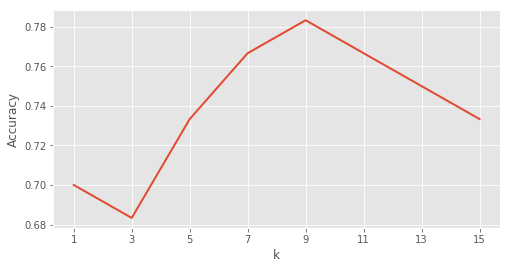

In [10]:
# 绘制不同 k 下的模型在 60 个测试集上的精确率曲线，matplotlab可视化,
# 可以看出 k=9 时有 0.783 的精确率
classify_model = my_knn()
plt.figure(figsize=(8,4))
n = np.array([1,3,5,7,9,11,13,15])
predict_knn = np.zeros((n.shape[0],60))
scores_knn = np.zeros((n.shape[0]))
for idx,nn in enumerate(n):
    classify_model.fit(all_img_hog[:300], all_img_labels[:300])
    predict_knn[idx] = classify_model.predict(all_img_hog[300:], nn)
    scores_knn[idx] = classify_model.score(all_img_labels[300:])
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.xticks(n)
plt.plot(n,scores_knn,ls='-',lw=2,label='knn accuracy')
scores_knn

In [11]:
# 定义生成在最高精确率下模型的混淆矩阵和准确率，召回率的函数，用 pandas 库可视化
import pandas as pd
def confusion_and_probability_matrix(scores,predict_result,tru_labels):
    idx = int(np.where(scores == scores.max())[0])
    pre = predict_result[idx]
    tru = tru_labels
    confusion_matrix = \
    pd.DataFrame({   'bubbly_predict':[np.logical_and(pre==0,tru==0).sum(), 
                    # 模型预测结果和真实值比较，用逻辑与和sum()函数计算矩阵值
                                       np.logical_and(pre==0,tru==1).sum(), 
                                       np.logical_and(pre==0,tru==2).sum(), 
                                       (pre==0).sum()],
                 'stratified_predict':[np.logical_and(pre==1,tru==0).sum(), 
                                       np.logical_and(pre==1,tru==1).sum(), 
                                       np.logical_and(pre==1,tru==2).sum(), 
                                       (pre==1).sum()],
                     'veined_predict':[np.logical_and(pre==2,tru==0).sum(), 
                                       np.logical_and(pre==2,tru==1).sum(), 
                                       np.logical_and(pre==2,tru==2).sum(), 
                                       (pre==2).sum()], 
                                'sum':[(tru==0).sum(), (tru==1).sum(), 
                                       (tru==2).sum(), pre.shape[0]]},
                                index=['bubbly','stratified','veined','sum'])
    probability_matrix = \
    pd.DataFrame({'精确率(precision)':\
    [confusion_matrix['bubbly_predict'][0]/confusion_matrix['bubbly_predict'][3], 
    confusion_matrix['stratified_predict'][1]/confusion_matrix['stratified_predict'][3], 
    confusion_matrix['veined_predict'][2]/confusion_matrix['veined_predict'][3]],
    '召回率(recall)':\
    [confusion_matrix['bubbly_predict'][0]/confusion_matrix['sum'][0],
    confusion_matrix['stratified_predict'][1]/confusion_matrix['sum'][1],
    confusion_matrix['veined_predict'][2]/confusion_matrix['sum'][2]]},
    index=['bubbly','stratified','veined'])    
    return confusion_matrix, probability_matrix

In [12]:
confusion_matrix_knn, probability_matrix_knn = \
confusion_and_probability_matrix(scores_knn, predict_knn, all_img_labels[300:])
confusion_matrix_knn
# knn 在准确率最高时（0.783）的混淆矩阵以及模型精确率和召回率
#分析：模型在 bubbly 和 stratified 上 精确率和召回率都较好（基本高于准确率），
# 但在 veined 上的召回率较差（低于随机值 1/3 ）
#推测模型可能更趋于把 veined 分到 bubbly 上

,bubbly_predict,stratified_predict,veined_predict,sum
bubbly,24,2,0,26
stratified,1,19,0,20
veined,7,3,4,14
sum,32,24,4,60


In [13]:
probability_matrix_knn

,精确率(precision),召回率(recall)
bubbly,0.750000,0.923077
stratified,0.791667,0.950000
veined,1.000000,0.285714


In [14]:
#调用 sklearn 的 svm 和评分函数的相关模块，并整合成 2 个函数
from sklearn.svm import SVC
from sklearn import metrics
def train_svm(X_train, y_train,kenrel):
    svm = SVC(kernel=kenrel,
              class_weight='balanced',
              gamma='scale'
              )
    svm.fit(X_train, y_train)
    return svm
def score_svm(svm, X, y):
    y_pred = svm.predict(X)
    return metrics.accuracy_score(y, y_pred)

[0.73333333 0.7        0.43333333 0.68333333]


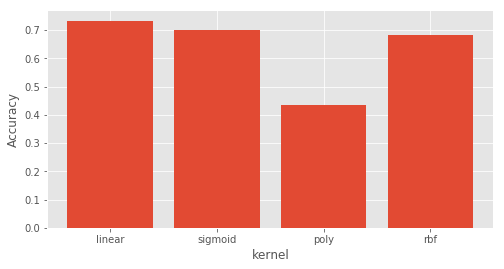

In [15]:
# 绘制不同核函数下的模型在 60 个测试集上的精确率条形图，matplotlab可视化，
# 可以看出 linear（线性） 核有 0.733 的精确率
n = np.array(['linear','sigmoid','poly','rbf'])
plt.figure(figsize=(8,4))
scores_svm = np.zeros((n.shape[0]))
predict_svm = np.zeros((n.shape[0],60))
for idx,kernel in enumerate(n):
    svm = train_svm(all_img_hog[:300], all_img_labels[:300],kernel)
    predict_svm[idx] = svm.predict(all_img_hog[300:])
    scores_svm[idx] = metrics.accuracy_score(all_img_labels[300:], predict_svm[idx])
plt.xlabel('kernel')
plt.ylabel('Accuracy')
plt.bar(n,scores_svm,align='center',ls=':',tick_label=n)
print(scores_svm)

In [16]:
confusion_matrix_svm,probability_matrix_svm = \
confusion_and_probability_matrix(scores_svm, predict_svm, all_img_labels[300:])
confusion_matrix_svm
# svm 在准确率最高时（0.733）的混淆矩阵以及模型精确率和召回率
#分析：模型除去 veined 其余两类的精确率和召回率都较好（基本高于准确率0.733），
#但与 knn 模型一样在 veined 上分类能力较差（远低于其余两类）
#推测模型在 veined 类上拟合较差

,bubbly_predict,stratified_predict,veined_predict,sum
bubbly,19,4,3,26
stratified,0,18,2,20
veined,4,3,7,14
sum,23,25,12,60


In [17]:
probability_matrix_svm

,精确率(precision),召回率(recall)
bubbly,0.826087,0.730769
stratified,0.720000,0.900000
veined,0.583333,0.500000
